In [277]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [407]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 40

In [279]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE        
)

Found 2152 files belonging to 3 classes.


In [280]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [281]:
#defining a function to count the samples in each class
def count_class(df):
    class_counts = {}
    for images, labels in df:
        for label in labels.numpy():
            class_name = class_names[label]
            if class_name not in class_counts:
                class_counts[class_name] = 0

            class_counts[class_name] += 1
    return class_counts

In [282]:
len(dataset)

68

In [283]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[0 0 1 1 1 1 1 0 1 0 0 0 1 0 2 1 1 1 0 2 0 1 1 1 2 0 1 1 1 1 0 1]


In [284]:
#function to visualize 12 images of first batch of the dataset
def visualize(df):
    plt.figure(figsize = (12,12))
    for image, label in df.take(1):
        for i in range(12):
            ax = plt.subplot(3,4,i+1)
            plt.imshow(image[i].numpy().astype("uint8"))
            plt.title(class_names[label[i]])
            plt.axis("off")

In [285]:
#counting the samples in each class
print(count_class(dataset))

{'Potato___Early_blight': 1000, 'Potato___healthy': 152, 'Potato___Late_blight': 1000}


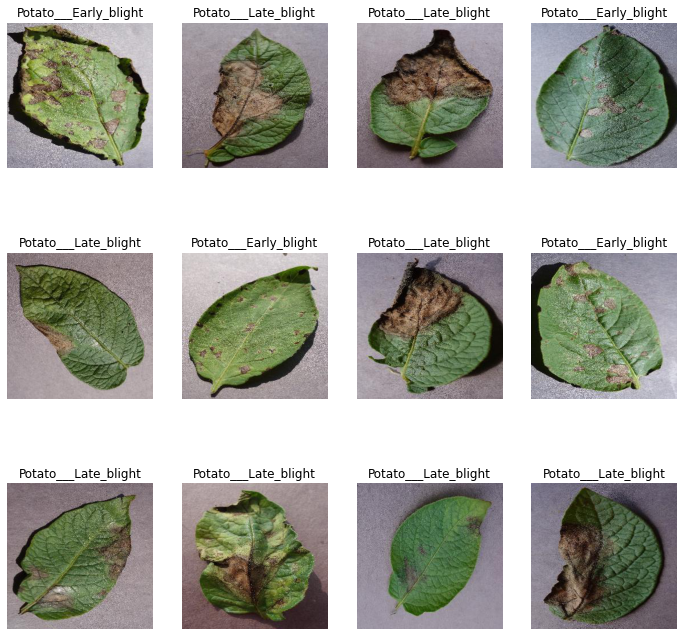

In [286]:
#visualizing the 12 images of the first batch our dataset
visualize(dataset)

# Splitting the dataset into train, test and validation dataset

In [287]:
#splitting the dataset
#80% => training 
#20% => validation and testing

In [288]:
def get_dataset_partition(ds, train_split = 0.8, test_split = 0.1, val_split = 0.1, shuffle = True, shuffle_size = 10000):
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 12)
        
    train_size = int(ds_size * train_split)
    val_size = int(ds_size * val_split)
    test_size = int(ds_size * test_split)
    
    train_ds = ds.take(train_size)
    
    val_ds = ds.skip(train_size).take(val_size)
    
    test_ds = ds.skip(train_size).skip(val_size)
    
    
    return train_ds, val_ds, test_ds
    

In [289]:
train_ds, val_ds, test_ds = get_dataset_partition(dataset)

# Training Dataset

In [290]:
len(train_ds)

54

In [291]:
#counting the samples in each class in training data set
print("Training Dataset:",count_class(train_ds))

Training Dataset: {'Potato___Late_blight': 814, 'Potato___Early_blight': 798, 'Potato___healthy': 116}


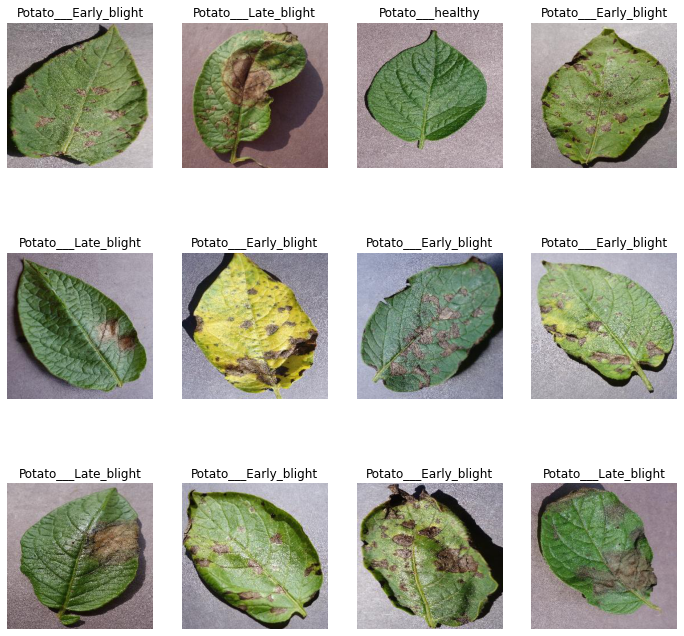

In [292]:
#visualizing training dataset
visualize(train_ds)

# Validation Dataset

In [293]:
len(val_ds)

6

In [294]:
print("Validation Dataset:", count_class(val_ds))

Validation Dataset: {'Potato___Early_blight': 83, 'Potato___Late_blight': 99, 'Potato___healthy': 10}


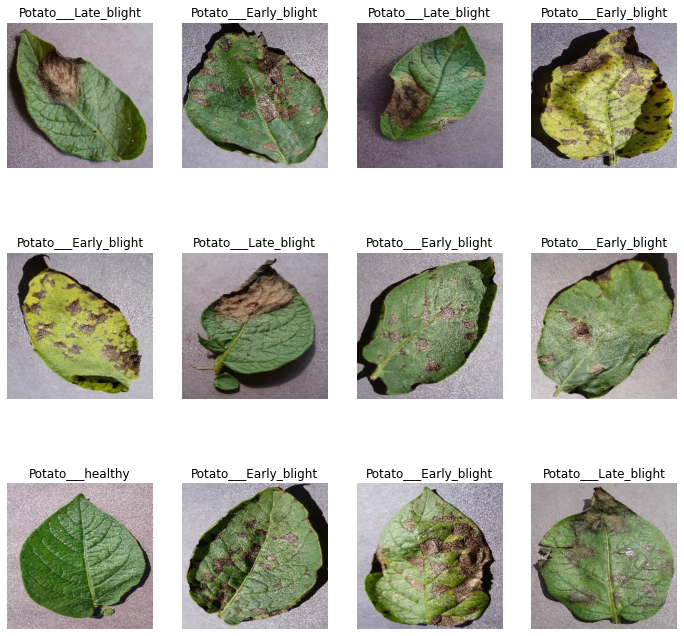

In [295]:
visualize(val_ds)

# Testing Dataset

In [296]:
len(test_ds)

8

In [297]:
print("Testing Dataset:", count_class(test_ds))

Testing Dataset: {'Potato___Late_blight': 105, 'Potato___Early_blight': 131, 'Potato___healthy': 20}


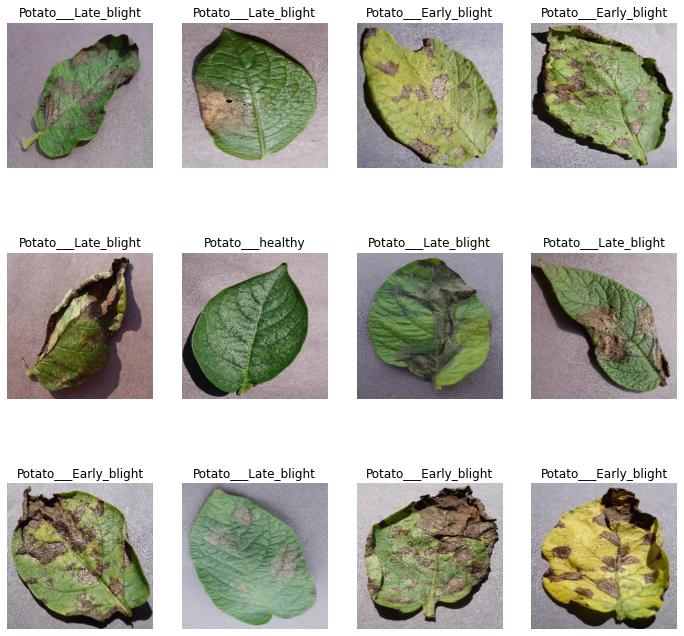

In [298]:
visualize(test_ds)

# Optimizing the dataset

In [299]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

# Preprocessing the images

In [301]:
resize_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255 )
])

In [302]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [304]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3), activation = 'relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(32,(3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation= 'relu'),
    layers.Dense(n_classes, activation = 'softmax')  
])

model.build(input_shape = input_shape)

In [306]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [307]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

In [408]:
history = model.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val_ds
)

Epoch 1/40
54/54 [==============================] - 39s 723ms/step - loss: 0.0993 - accuracy: 0.9630 - val_loss: 0.0922 - val_accuracy: 0.9583
Epoch 2/40
54/54 [==============================] - 35s 655ms/step - loss: 0.1491 - accuracy: 0.9468 - val_loss: 0.0945 - val_accuracy: 0.9688
Epoch 3/40
54/54 [==============================] - 48s 883ms/step - loss: 0.1029 - accuracy: 0.9635 - val_loss: 0.0732 - val_accuracy: 0.9740
Epoch 4/40
54/54 [==============================] - 38s 708ms/step - loss: 0.0650 - accuracy: 0.9792 - val_loss: 0.0693 - val_accuracy: 0.9792
Epoch 5/40
54/54 [==============================] - 42s 776ms/step - loss: 0.0582 - accuracy: 0.9792 - val_loss: 0.1510 - val_accuracy: 0.9531
Epoch 6/40
54/54 [==============================] - 38s 704ms/step - loss: 0.0526 - accuracy: 0.9774 - val_loss: 0.0549 - val_accuracy: 0.9792
Epoch 7/40
54/54 [==============================] - 38s 713ms/step - loss: 0.0584 - accuracy: 0.9821 - val_loss: 0.0603 - val_accuracy: 0.9740

In [409]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 2s 310ms/step - loss: 0.0466 - accuracy: 0.9844


In [410]:
scores

[0.046554870903491974, 0.984375]

# Visualizing the results our model

In [411]:
history

In [412]:
history.params

{'verbose': 1, 'epochs': 40, 'steps': 54}

In [413]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [414]:
len(history.history['accuracy'])

40

In [415]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']


loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Accuracy')

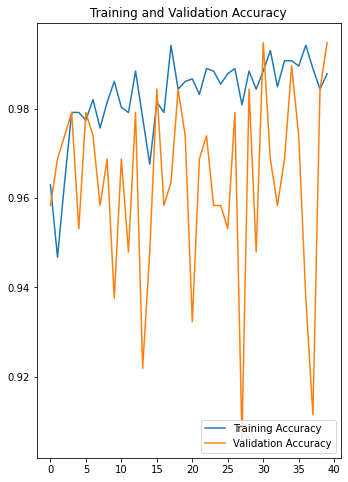

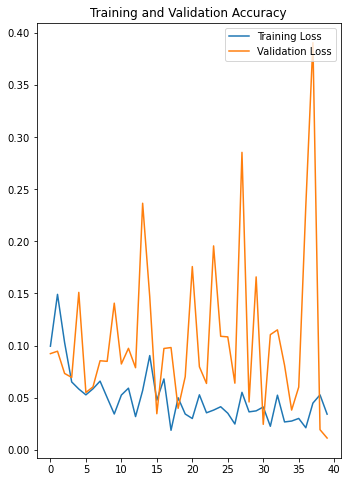

In [416]:
plt.figure(figsize = (12,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label = "Training Accuracy")
plt.plot(range(EPOCHS), val_acc, label = "Validation Accuracy")
plt.legend(loc = 'lower right')
plt.title("Training and Validation Accuracy")


plt.figure(figsize = (12,8))
plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label = "Training Loss")
plt.plot(range(EPOCHS), val_loss, label = "Validation Loss")
plt.legend(loc = 'upper right')
plt.title("Training and Validation Accuracy")


# Prediction

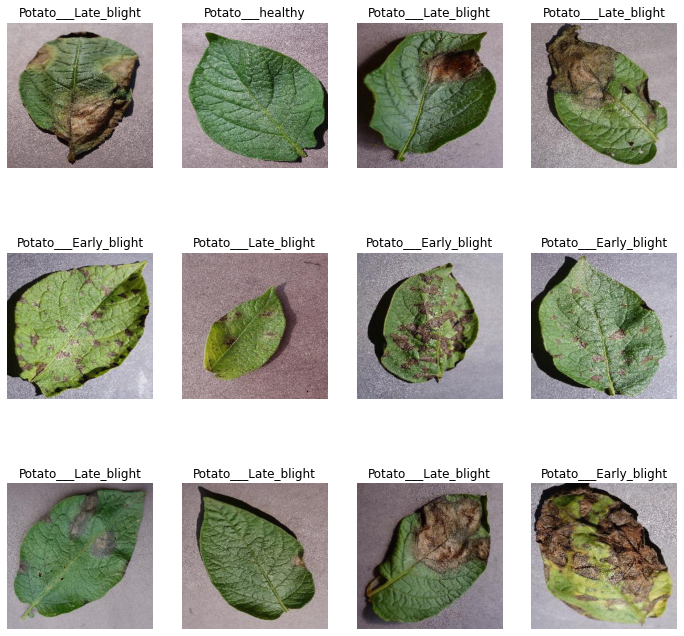

In [417]:
visualize(test_ds)

Actual Label: Potato___Early_blight
Predicted label: Potato___Early_blight


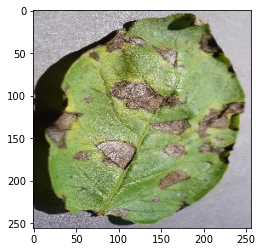

In [418]:

import numpy as np
for image_batch, image_label in test_ds.take(1):
    
    first_image = image_batch[0].numpy().astype("uint8")
    first_label = image_label[0].numpy()

        
    print("Actual Label:", class_names[first_label])


    batch_prediction = model.predict(image_batch)
    print("Predicted label:",class_names[np.argmax(batch_prediction[0])])
    
    plt.imshow(first_image)

    

In [419]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) #create a batch
    
    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    
    return predicted_class, confidence

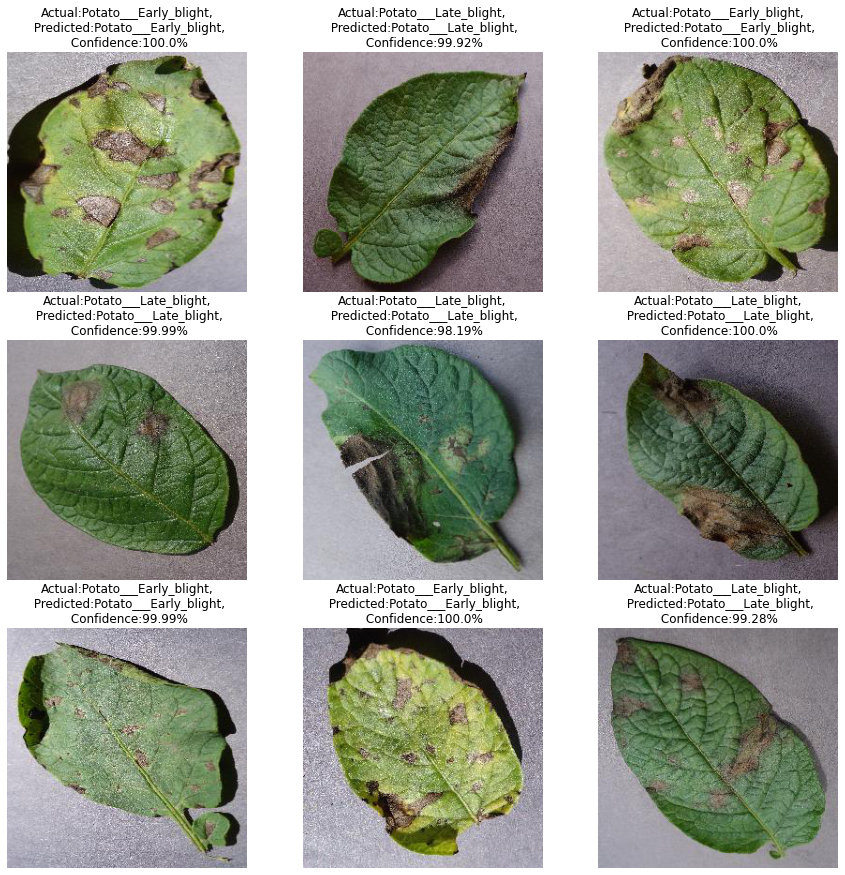

In [420]:
plt.figure(figsize = (15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        
        plt.imshow(images[i].numpy().astype('uint8'))
        
        plt.title(f"Actual:{actual_class},\n Predicted:{predicted_class},\n Confidence:{confidence}%")
        plt.axis("off")

In [429]:
tf.keras.models.save_model(model, 'model.h5', save_format='h5')